<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Fabrice Jimenez | <a href="https://supaerodatascience.github.io/machine-learning/">https://supaerodatascience.github.io/machine-learning/</a>

# Anomaly Detection - Practical Follow-up

This notebook is following the progression of the Anomaly Detection class. It provides practical illustrations in Python and short exercises to understand the notions we have seen in this course.

<div class="alert alert-warning">
Author: Fabrice JIMENEZ
    
Link to course materials: https://github.com/SupaeroDataScience/machine-learning/tree/main/13%20-%20Anomaly%20Detection
</div>

## Preliminary loading with Google Colab

If you are using this notebook with Google Colab, please execute first the following cells, to retrieve the GitHub repository content. Otherwise, ignore these cells and move to the next section.

In [ ]:
import os
os.mkdir('data')

In [ ]:
!wget -c https://github.com/SupaeroDataScience/machine-learning/blob/main/13%20-%20Anomaly%20Detection/data/X1.npy?raw=true -O data/X1.npy
!wget -c https://github.com/SupaeroDataScience/machine-learning/blob/main/13%20-%20Anomaly%20Detection/data/X1_1.npy?raw=true -O data/X1_1.npy
!wget -c https://github.com/SupaeroDataScience/machine-learning/blob/main/13%20-%20Anomaly%20Detection/data/X2.npy?raw=true -O data/X2.npy

## Imports and Loading Dataset

The dataset is sampled from random gaussian distributions.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [10, 5]

In [36]:
X1 = np.load('data/X1.npy')
X1_1 = np.load('data/X1_1.npy') # Variable X1 with far outlier
X2 = np.load('data/X2.npy')
df = pd.DataFrame()
df['X1'] = X1
df['X1_1'] = X1_1
df['X2'] = X2

In [5]:
df.head()

,X1,X1_1,X2
0,12.662034,12.662034,-6.607371
1,-9.890820,-9.890820,4.638357
2,-7.646777,-7.646777,4.984616
3,-4.753542,-4.753542,-2.287770
4,8.975483,8.975483,7.568073


## Useful Functions

Don't worry about these functions at the moment, they will be used later to plot some results.

In [6]:
def plotAnomalies1D(s, anomalies, threshold1, threshold2):
    """
        s: Pandas Series containing all the points to plot
        anomalies: Pandas Series containing all the points which are anomalies
        threshold1: Float value - minimum threshold to be normal
        threshold2: Float value - maximum threshold to be normal
    """
    plt.figure()
    plt.plot(s, [0]*len(s), 'bo')
    plt.plot(anomalies, [0]*len(anomalies), 'ro')
    plt.plot([threshold1]*2, [-1,1], 'g--')
    plt.plot([threshold2]*2, [-1,1], 'g--')

In [7]:
def plotAnomalies2D(df, clf_name, clf):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    plt.figure()
    plt.plot(df['X1'],df['X2'], 'o')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim([df['X1'].min()-3,df['X1'].max()+3])
    plt.ylim([df['X2'].min()-3,df['X2'].max()+3])
    plt.title(clf_name)
    
    if clf_name == 'LOF':
        ypred = clf.fit_predict(df[['X1','X2']])
        plt.plot(df['X1'][ypred==-1],df['X2'][ypred==-1],'ro')
    else:
        xx, yy = np.meshgrid(np.linspace(df['X1'].min()-3,df['X1'].max()+3, 500), np.linspace(df['X2'].min()-3,df['X2'].max()+3, 500))
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='r')

In [8]:
def plotAnomalyScore2D(df, clf_name, clf):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    if clf_name == 'LOF':
        score = clf.negative_outlier_factor_
    else:
        score = clf.decision_function(df[['X1','X2']])
    
    plt.figure()
    sc = plt.scatter(x=df['X1'],y=df['X2'], c=-score, cmap='Reds')
    plt.colorbar(sc, label='anomaly score')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(clf_name)

## Univariate Outlier Detection

In this section, let's consider a single variable x = X1. Let's visualize the dataset in different ways...

In [37]:
x = 'X1'

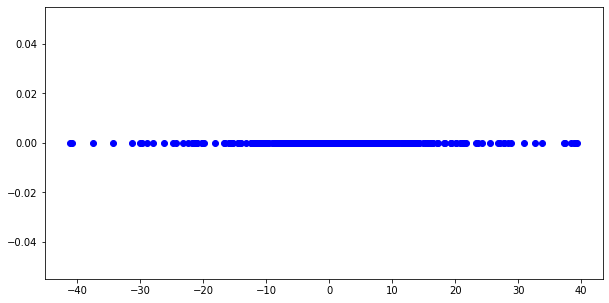

In [10]:
# Scatter plot
plt.figure()
plt.plot(df[x], [0]*len(df), 'bo')

<AxesSubplot:>

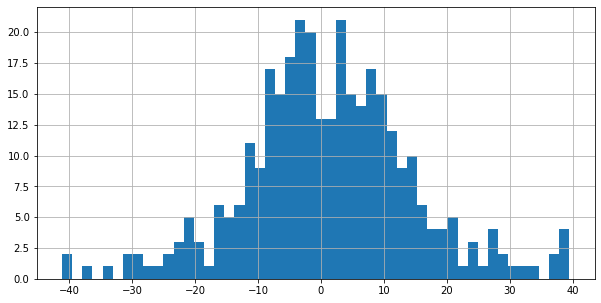

In [11]:
# Histogram
df[x].hist(bins=50)

In [12]:
# Key statistical indicators
df[x].describe()

count    330.000000
mean       1.119313
std       13.497184
min      -41.112042
25%       -6.482452
50%        0.676623
75%        8.979254
max       39.395503
Name: X1, dtype: float64

<div class="alert alert-warning">
Question 1: if you had to detect outliers in this 1D dataset, how would you do?
</div>

Implement your own 1D outlier detection method. To do this, you need to compute:
- <em>threshold1</em> : Float value - minimum threshold to be normal
- <em>threshold2</em> : Float value - maximum threshold to be normal
- <em>anomalies</em> : Pandas Series containing all the points which are anomalies

In [53]:
###### CODE HERE ######
## Using meand and deviation
mu = df[x].mean()
sig = df[x].std()
threshold1 = mu - 2*sig
threshold2 = mu + 2*sig
anomalies = df[x][abs(df[x]-mu)>2*sig].copy()

## Using median and MAD (more robust)
# MAD = median of differences between values and median
med = df[x].median()
mad = (df[x] - med).abs().median()

threshold1 = med - 3*mad
threshold2 = med + 3*mad
anomalies = df[x][(df[x] - med).abs() > 3*mad].copy()
#######################

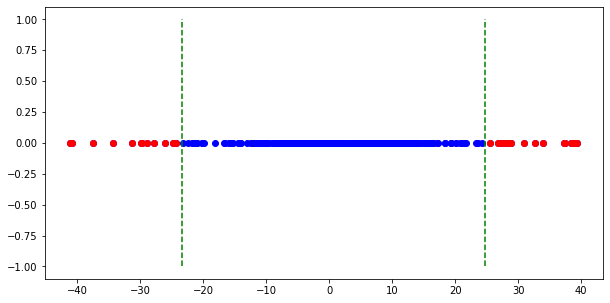

In [54]:
plotAnomalies1D(df[x], anomalies, threshold1, threshold2)

<div class="alert alert-warning">
Question 2: What is the impact of far outliers on the method(s) you used?
</div>

Test your method(s) on variable <em>X1_1</em> instead of <em>X1</em> : 1 single point was changed, to become a very large value.

## Multivariate Outlier Detection

In this section, let's consider 2 variables X1 and X2. Let's visualize the dataset.

Text(0, 0.5, 'X2')

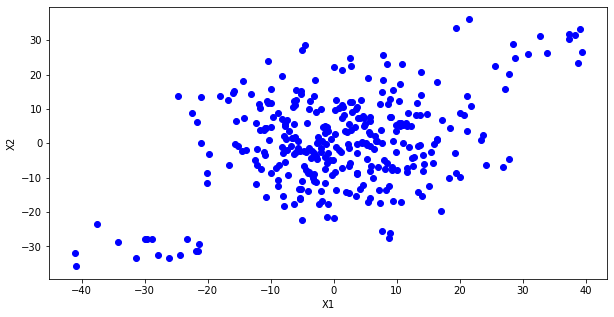

In [55]:
plt.figure()
plt.plot(df['X1'],df['X2'], 'bo')
plt.xlabel('X1')
plt.ylabel('X2')

We will experiment here with the 4 different outlier detection methods we have just seen in class. These methods are directly available in Scikit-Learn.

<div class="alert alert-warning">
Question 3: What is the impact of hyperparameters on the detection boundaries / anomalies detected, for each method?
</div>

<b>Question 3.a:</b> For example, compare the behavior of the different models, with contamination rate at same value. What models appear to be easy to tune (without taking into account contamination rate)?

<b>Question 3.b:</b> For example, compare the behavior of different contamination rates, with the same model. What difficulties are you facing?

In [56]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [77]:
cr = 0.15

In [78]:
clf_name = 'Elliptic Envelope'
clf = EllipticEnvelope(contamination=cr)
clf.fit(df[['X1','X2']])

EllipticEnvelope(contamination=0.15)

In [79]:
clf2_name = 'Isolation Forest'
clf2 = IsolationForest(n_estimators=300, contamination=cr)
clf2.fit(df[['X1','X2']])

IsolationForest(contamination=0.15, n_estimators=300)

In [96]:
clf3_name = 'Local Outlier Factor' # plus dur à calibrer (nb de neighbors)
clf3 = LocalOutlierFactor(n_neighbors=35, contamination=cr, novelty=True)
clf3.fit(df[['X1','X2']])

LocalOutlierFactor(contamination=0.15, n_neighbors=35, novelty=True)

In [92]:
clf4_name = 'One Class SVM'
clf4 = OneClassSVM(nu=cr, kernel="rbf", gamma=0.5) # nu corresponds to contamination
clf4.fit(df[['X1','X2']])

OneClassSVM(gamma=0.5, nu=0.15)

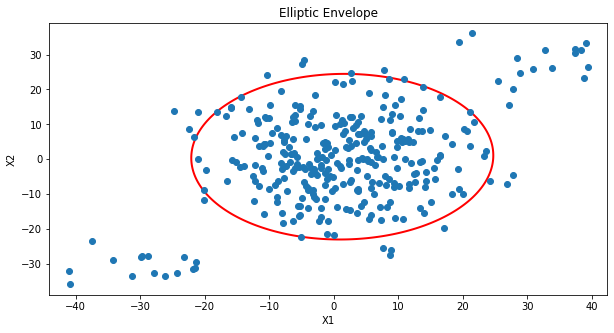

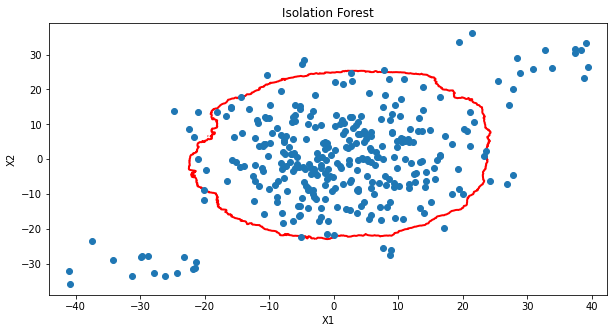

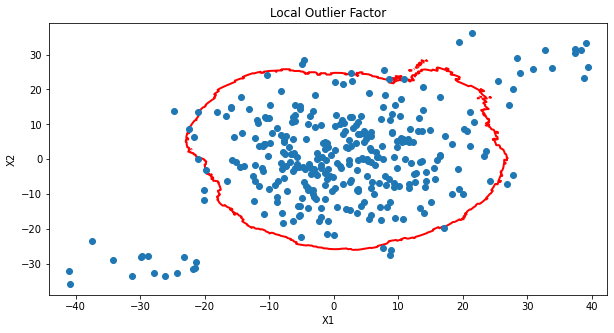

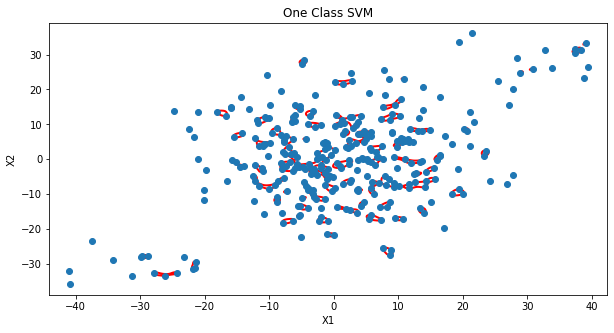

In [97]:
plotAnomalies2D(df, clf_name, clf)
plotAnomalies2D(df, clf2_name, clf2)
plotAnomalies2D(df, clf3_name, clf3)
plotAnomalies2D(df, clf4_name, clf4)

<div class="alert alert-warning">
Question 4: What alternative do you have instead of tuning the contamination rate?
</div>

Let's compute and visualize, for each model, the continuous anomaly scores.

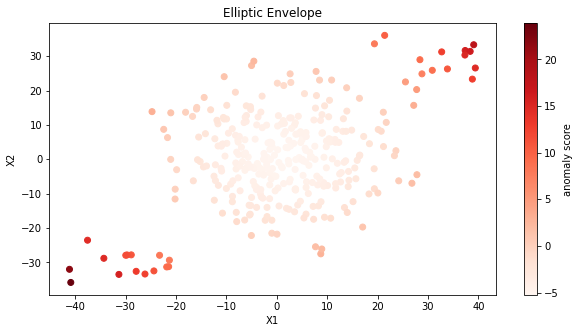

In [98]:
plotAnomalyScore2D(df, clf_name, clf)

Essayer toujours de croiser ces méthodes de détection avec d'abord visualisation du score d'naomalie plutôt que méthode de décision automatique donnée avec classe et visualisation des données PCA ... pour l'explicabilité de ton modèle !

## Novelty Detection

In this section, we split the dataset to have on one side the normal points, and on the other side the new points which are anomalies.

In [99]:
normal_df = df.iloc[:300].copy()
new_anomalies = df.iloc[300:].copy()

Text(0, 0.5, 'X2')

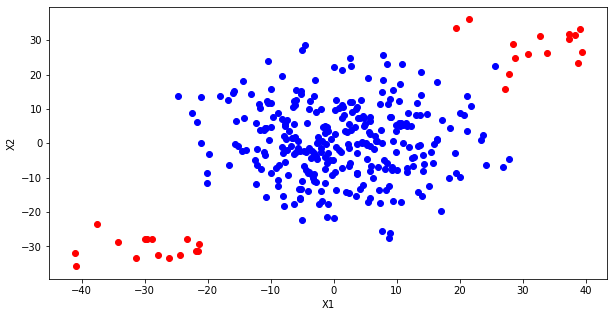

In [100]:
plt.figure()
plt.plot(normal_df['X1'], normal_df['X2'], 'bo')
plt.plot(new_anomalies['X1'], new_anomalies['X2'], 'ro')
plt.xlabel('X1')
plt.ylabel('X2')

The purpose of novelty detection is to learn the behavior of normal points. We can use unsupervised methods such as those we have seen earlier, but we can also use supervised learning.

<div class="alert alert-warning">
Question 5: Implement your novelty detection approach using supervised learning, to predict each variable in function of the others.
</div>

To do this, you have to select a supervised model $\tilde{f}$ to learn the relationship between X1 and X2. 

$$
\tilde{X}_2 = \tilde{f}\left(X_1\right)
$$You need to compute:
- <em>ypred_normal</em> : an array containing the predicted values for the normal dataset
- <em>ypred_anomalies</em> : an array containing the predicted values for the new anomalies dataset

In [102]:
X = np.array(normal_df['X1']).reshape(-1,1)
y = np.array(normal_df['X2'])

In [107]:
###### CODE HERE ######
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=101)
rf.fit(X,y)
ypred_normal = rf.predict(X)
ypred_anomalies = rf.predict(np.array(new_anomalies['X1']).reshape(-1,1))
#######################

Let's visualize the superposition of actual values and the predicted values, as scatter plot.

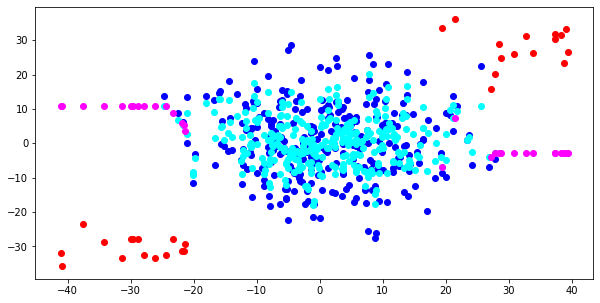

In [108]:
# Superposition
plt.figure()
plt.scatter(x=normal_df['X1'],y=normal_df['X2'],c='b')
plt.scatter(x=normal_df['X1'],y=ypred_normal,c='cyan')

plt.scatter(x=new_anomalies['X1'],y=new_anomalies['X2'],c='r')
plt.scatter(x=new_anomalies['X1'],y=ypred_anomalies,c='magenta')

We can also look at the predicted values versus the actual values, for normal and anomaly points.

Text(0, 0.5, 'Predicted values')

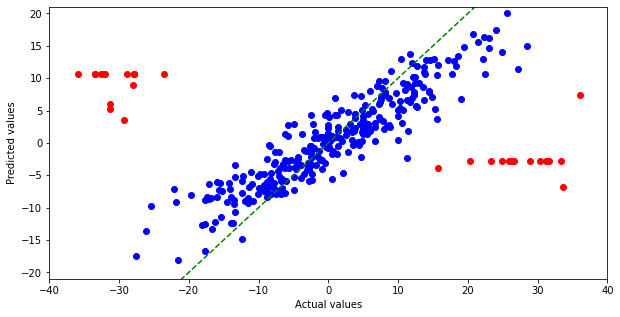

In [109]:
# Value / Value plot
plt.figure()
plt.scatter(x=normal_df['X2'], y=ypred_normal, c='b')
plt.scatter(x=new_anomalies['X2'], y=ypred_anomalies,c='r')
plt.plot([-50,50], [-50,50], 'g--')
plt.xlim([-40,40])
plt.ylim([-21,21])
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

<div class="alert alert-warning">
Question 6: To compute an anomaly score, we will use the prediction error of the model. Compute for example the mean squared error for normal points and anomaly points.
</div>

In [113]:
###### CODE HERE ######
error_normal = (ypred_normal-normal_df['X2'])**2
error_anomalies = (ypred_anomalies-new_anomalies['X2'])**2
mse_normal = np.mean(error_normal)
mse_anomalies = np.mean(error_anomalies)
print('normal: ', mse_normal)
print('anomalies: ', mse_anomalies)
#######################

normal:  24.095753181183962
anomalies:  1276.8905816512008


Finally, let's visualize the prediction error as color levels.

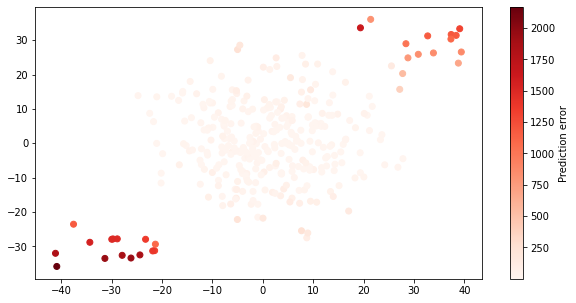

In [114]:
plt.figure()
sc = plt.scatter(x=list(normal_df['X1']) + list(new_anomalies['X1']), 
            y=list(normal_df['X2']) + list(new_anomalies['X2']), 
            c=list(error_normal) + list(error_anomalies),
            cmap='Reds')
plt.colorbar(sc, label='Prediction error')

It looks like a pretty good anomaly score!